In [1]:
from __future__ import (division, print_function,
                        unicode_literals, absolute_import)

import numpy as np
import scipy.integrate as si
import matplotlib.pyplot as plt

%matplotlib inline

# Bayesian Statistics for Data Analysis

## Paul T. Baker

Some resourses I like:

 * Allen B Downey, *Think Bayes: Bayesian Statistics Made Simple*, Green Tea Press (2012)
 * Phil Gregory, *Bayesian Logical Data Analysis for the Physical Sciences: A Comparative Approach*, Cambridge University Press (2010)
 * William M. Bolstad, *Understanding Computational Bayesian Statistics*, Wiley (2009)

## Example: fitting a spectral line

We have some noisy data containing a possible novel spectral line feature.  The spectrum is measured as a temperature anomaly, $dT$, from the mean observed temperature in each frequency channel.

Some Theory predicts the line will have a gaussian shape:

$$dT = T_0 \exp\left( \frac{-(\nu-\nu_0)^2}{2{\sigma_L}^2} \right),$$

where $T_0$ is the amplitude of the feature that according to the theory can range from 0.1-100 mK.  The frequency $\nu$ is measured in channel number for our instrument, and the theory says line should appear in channel $\nu_0=37$ with width $\sigma_L=2$.

Our instrument has white radiometer noise at a level of $\sigma=1$ mK.

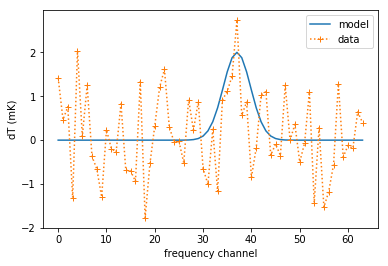

In [2]:
def line_model(v, T0=1, v0=37, sigL=2):
    v = np.asarray(v)
    arg = (0.5*(v-v0)/sigL)**2
    return T0 * np.exp(-arg)

data = np.loadtxt("spec.dat")
freq = np.arange(64)
mod = line_model(freq, T0=2)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(freq, mod, label='model')
ax.plot(freq, data, marker='+', linestyle=':', label='data')
ax.set_ylabel('dT (mK)')
ax.set_xlabel('frequency channel')
ax.legend()
fig.savefig('spect.pdf')

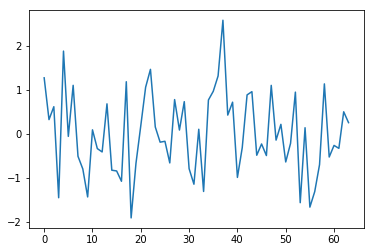

In [3]:
t0 = data - data.mean()
plt.plot(t0)
#data = t0

In [4]:
N = len(data)
sigN = 1  # noise stdev

norm = (np.sqrt(2*np.pi)*sigN)**-N
arg = 0.5*np.sum(data**2)/sigN**2
pdH0 = norm * np.exp(-arg)
print(pdH0)

1.13286736363e-38


In [5]:
Tmin = 0.1
Tmax = 100.
def integrand(T):
    pTH1 = 1/T / np.log(Tmax/Tmin)
    
    model = line_model(freq, T0=T, v0=37, sigL=2) 
    
    norm = (np.sqrt(2*np.pi)*sigN)**-N
    resid = data-model
    arg = 0.5*np.sum(resid**2)/sigN**2
    pdH1T = norm * np.exp(-arg)
    
    return pdH1T * pTH1

Ts = np.logspace(-1, 2, 100)  # 
#Ts = np.linspace(0.1, 100, 1000)
pdH1T_pts = np.array([integrand(T) for T in Ts])
pdH1 = si.simps(pdH1T_pts, Ts)  # simpson's integrater!
print(pdH1)  # 1.24e-37 according to book

6.55368726805e-38


In [6]:
O = pdH1 / pdH0
print(O)

5.78504375571


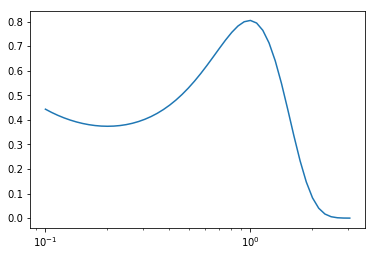

In [7]:
n = len(Ts)//2
plt.plot(Ts[:n], pdH1T_pts[:n]/pdH1)
plt.xscale('log')

In [8]:
np.sum(pdH1T_pts[:-1]/pdH1 * np.diff(Ts))

1.0373109018023645